In [1]:
from __future__ import annotations
import numpy as np
import cv2
import tifffile as tiff
from typing import List, Sequence, Tuple

In [ ]:
def place_and_downscale_tiffs(
    paths: Sequence[str],
    coords: Sequence[Tuple[int, int]],
    page: int = 0,
    max_side: int = 600,
    cap: float = 0.33,
    background: int = 0,
    pad_to_square: bool = False,
    scaler : float= 1.0
) -> np.ndarray:
    if len(paths) != len(coords):
        raise ValueError("paths and coords must have the same length")

    imgs = [tiff.imread(p) for p in paths]
    
    # Decide output color mode: RGB if any image is color, else grayscale
    any_color = any(im.ndim == 3 and im.shape[2] >= 3 for im in imgs)
    
    xs, ys = [], []
    for (x, y), im in zip(coords, imgs):
        h, w = im.shape[:2]
        xs.extend([x, x + w])
        ys.extend([y, y + h])
    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    bbox_w = max_x - min_x
    bbox_h = max_y - min_y
    if bbox_w <= 0 or bbox_h <= 0:
        raise ValueError("Invalid bounding box; check coordinates and images.")

    fit_scale = min(max_side / max(bbox_w, bbox_h), 1.0)
    s = min(cap, fit_scale)  # never > cap; never >1 due to fit_scale
    #s = s * scaler
    print(s)
    out_w = max(1, int(np.ceil(bbox_w * s)))
    out_h = max(1, int(np.ceil(bbox_h * s)))

    if any_color:
        canvas = np.full((out_h, out_w, 3), background, dtype=np.uint8)
    else:
        canvas = np.full((out_h, out_w), background, dtype=np.uint8)

    for (x, y), im in zip(coords, imgs):
        # Convert grayscale to 3ch if needed
        if any_color and im.ndim == 2:
            im = np.stack([im, im, im], axis=2)
        elif (not any_color) and im.ndim == 3:
            # Convert color to gray via luminance weights
            im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

        h, w = im.shape[:2]
        new_w = max(1, int(round(w * s)))
        new_h = max(1, int(round(h * s)))
        im_s = cv2.resize(im, (new_w, new_h), interpolation=cv2.INTER_AREA)

        tx = int(round((x - min_x) * s))
        ty = int(round((y - min_y) * s))
        x0 = max(0, tx)
        y0 = max(0, ty)
        x1 = min(out_w, tx + new_w)
        y1 = min(out_h, ty + new_h)
        if x0 >= x1 or y0 >= y1:
            continue  # completely out of bounds after scaling

        sx0 = x0 - tx
        sy0 = y0 - ty
        sx1 = sx0 + (x1 - x0)
        sy1 = sy0 + (y1 - y0)

        canvas[y0:y1, x0:x1] = im_s[sy0:sy1, sx0:sx1]

    if not pad_to_square:
        return canvas

    # Optional square padding to exactly max_side x max_side (centered)
    sq = np.full((max_side, max_side) + (() if canvas.ndim == 2 else (canvas.shape[2],)), background, dtype=np.uint8)
    y_off = (max_side - out_h) // 2
    x_off = (max_side - out_w) // 2
    y_off = max(0, y_off); x_off = max(0, x_off)
    y1 = min(max_side, y_off + out_h)
    x1 = min(max_side, x_off + out_w)
    sub = canvas[:(y1 - y_off), : (x1 - x_off)]
    sq[y_off:y1, x_off:x1] = sub
    return sq


In [18]:
import re
from dataclasses import dataclass
from typing import List

@dataclass
class ImageRecord:
    filename: str
    x: int
    y: int
    z: float
    r_stage: float
    exposure: float

def parse_tiff_metadata(text: str) -> List[ImageRecord]:
    """
    Parse metadata lines of the form:
    path\\file.tif ; x,y,z,r_stage ;exposure
    and return a list of ImageRecord dataclasses.
    """
    pattern = re.compile(
        r'(?P<filename>[A-Za-z]:\\[^\s;]+\.tif)\s*;\s*'
        r'(?P<x>-?\d+),(?P<y>-?\d+),(?P<z>-?\d+(?:\.\d+)?),(?P<r_stage>-?\d+(?:\.\d+)?)\s*;\s*(?P<exposure>-?\d+(?:\.\d+)?)'
    )

    results = []
    for m in pattern.finditer(text):
        results.append(
            ImageRecord(
                filename=m.group('filename'),
                x=int(m.group('x')),
                y=int(m.group('y')),
                z=float(m.group('z')),
                r_stage=float(m.group('r_stage')),
                exposure=float(m.group('exposure')),
            )
        )
    return results


In [28]:
from typing import Union

In [29]:
def place_with_scale(
    paths: Sequence[str],
    coords: Sequence[Tuple[float, float]],
    *,
    coord_scale: Union[float, Tuple[float, float]] = 1.0,  # convert input coord units -> pixels
    layout_scale: float = 1.0,      # additional uniform multiplier for coordinates
    img_scale: float | None = None, # per-tile image scale; if None, uses layout_scale
    coord_is_center: bool = False,  # True if coords denote tile centers
    flip_y: bool = False,           # True if stage y increases upward
    background: int = 0,
    pad_to_square: bool = False,
    pad_size: int = 600
):
    if len(paths) != len(coords):
        raise ValueError("paths and coords must have the same length")
    if img_scale is None:
        img_scale = layout_scale

    # Read tiles
    imgs = [tiff.imread(p) for p in paths]
    any_color = any(im.ndim == 3 and im.shape[2] == 3 for im in imgs)

    # coord_scale handling
    if isinstance(coord_scale, (int, float)):
        sx = sy = float(coord_scale)
    else:
        sx, sy = float(coord_scale[0]), float(coord_scale[1])

    # Compute unpadded bounding box after applying coord_scale & layout_scale and optional center shift
    xs, ys = [], []
    placements = []  # (x0, y0, w_s, h_s) after scales
    for (x_in, y_in), im in zip(coords, imgs):
        h, w = im.shape[:2]
        # scaled image size
        new_w = max(1, int(round(w * img_scale)))
        new_h = max(1, int(round(h * img_scale)))

        # scale / flip coords into pixel space
        x_px = x_in * sx
        y_px = (-y_in if flip_y else y_in) * sy

        if coord_is_center:
            x0 = (x_px - w/2) * layout_scale
            y0 = (y_px - h/2) * layout_scale
        else:
            x0 = x_px * layout_scale
            y0 = y_px * layout_scale

        placements.append((x0, y0, new_w, new_h))
        xs.extend([x0, x0 + new_w])
        ys.extend([y0, y0 + new_h])

    min_x, max_x = min(xs), max(xs)
    min_y, max_y = min(ys), max(ys)
    out_w = max(1, int(np.ceil(max_x - min_x)))
    out_h = max(1, int(np.ceil(max_y - min_y)))

    # Allocate canvas
    canvas = (np.full((out_h, out_w, 3), background, np.uint8)
              if any_color else
              np.full((out_h, out_w), background, np.uint8))

    # Paste tiles
    for (x0, y0, new_w, new_h), im in zip(placements, imgs):
        # Resize tile
        im_s = cv2.resize(im, (new_w, new_h), interpolation=cv2.INTER_AREA)

        # Match channels
        if any_color and im_s.ndim == 2:
            im_s = np.stack([im_s]*3, axis=2)
        elif (not any_color) and im_s.ndim == 3:
            im_s = cv2.cvtColor(im_s, cv2.COLOR_RGB2GRAY)

        # Translate to canvas coords with origin shift
        tx = int(np.floor(x0 - min_x))
        ty = int(np.floor(y0 - min_y))

        # Clip
        xL = max(0, tx); yT = max(0, ty)
        xR = min(out_w, tx + new_w); yB = min(out_h, ty + new_h)
        if xL >= xR or yT >= yB:
            continue
        sx0 = xL - tx; sy0 = yT - ty
        sx1 = sx0 + (xR - xL); sy1 = sy0 + (yB - yT)
        canvas[yT:yB, xL:xR] = im_s[sy0:sy1, sx0:sx1]

    if not pad_to_square:
        return canvas

    # Square pad to pad_size
    sq = np.full((pad_size, pad_size) + (() if canvas.ndim == 2 else (canvas.shape[2],)), background, np.uint8)
    y_off = max(0, (pad_size - out_h) // 2)
    x_off = max(0, (pad_size - out_w) // 2)
    y1 = min(pad_size, y_off + out_h)
    x1 = min(pad_size, x_off + out_w)
    sq[y_off:y1, x_off:x1] = canvas[:(y1 - y_off), :(x1 - x_off)]
    return sq

In [ ]:
metadata = r'D:\2025QPSC\data\1\ppm_10x_1\bounds\image_positions_metadata.txt'
with open(metadata, 'r') as fid:
    pos_str = fid.read()
pos = parse_tiff_metadata(pos_str)
pos_n7 = [p for p in pos if p.r_stage==-7]


In [25]:
pos_n7

[ImageRecord(filename='D:\\2025QPSC\\data\\1\\ppm_10x_1\\Raw\\bounds\\-7.0\\0.tif', x=12871, y=4082, z=-2811.7000000000003, r_stage=-7.0, exposure=50.0),
 ImageRecord(filename='D:\\2025QPSC\\data\\1\\ppm_10x_1\\Raw\\bounds\\-7.0\\1.tif', x=14288, y=4082, z=-2811.7000000000003, r_stage=-7.0, exposure=50.0),
 ImageRecord(filename='D:\\2025QPSC\\data\\1\\ppm_10x_1\\Raw\\bounds\\-7.0\\2.tif', x=14288, y=5142, z=-2811.7000000000003, r_stage=-7.0, exposure=50.0),
 ImageRecord(filename='D:\\2025QPSC\\data\\1\\ppm_10x_1\\Raw\\bounds\\-7.0\\3.tif', x=12871, y=5142, z=-2811.7000000000003, r_stage=-7.0, exposure=50.0)]

In [42]:
arr = place_and_downscale_tiffs(
    paths = [p.filename for p in pos_n7], #: Sequence[str],
    coords= [(p.x,p.y) for p in pos_n7], #Sequence[Tuple[int, int]],
    #page: int = 0,
    #max_side: int = 600,
    #cap: float = 0.33,
    #background: int = 0,
    #pad_to_square: bool = False
    scaler = 0.68
    
) 
#imshow(arr)

0.11720769893708705


In [13]:
%matplotlib inline
from matplotlib.pyplot import *

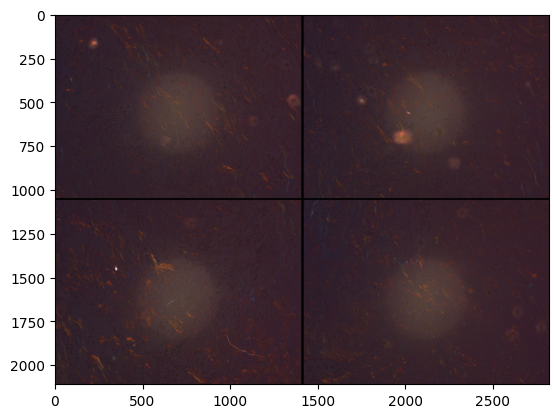

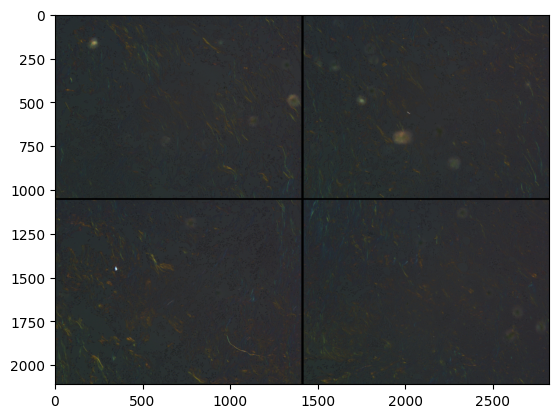

In [44]:
#pos = parse_tiff_metadata(pos_str)
pos_n7 = [p for p in pos if p.r_stage==0]

arr2 = place_with_scale(coord_scale= 1, img_scale= 0.68,layout_scale= 1,
    paths = [p.filename for p in pos_n7], #: Sequence[str],
    coords= [(p.x,p.y) for p in pos_n7], #Sequence[Tuple[int, int]],
    ) 
imshow(arr2)

figure()
arr2 = place_with_scale(coord_scale= 1, img_scale= 0.68,layout_scale= 1,
    paths = [p.filename.replace("Raw\\bounds","bounds") for p in pos_n7], #: Sequence[str],
    coords= [(p.x,p.y) for p in pos_n7], #Sequence[Tuple[int, int]],
    ) 
imshow(arr2)

In [46]:
#pos = parse_tiff_metadata(pos_str)
pos_p7 = [p for p in pos if p.r_stage==7]
pos_n7 = [p for p in pos if p.r_stage==-7]

parr2 = place_with_scale(coord_scale= 1, img_scale= 0.68,layout_scale= 1,
    paths = [p.filename for p in pos_p7], #: Sequence[str],
    coords= [(p.x,p.y) for p in pos_p7], #Sequence[Tuple[int, int]],
)
narr2 = place_with_scale(coord_scale= 1, img_scale= 0.68,layout_scale= 1,
    paths = [p.filename for p in pos_n7], #: Sequence[str],
    coords= [(p.x,p.y) for p in pos_n7], #Sequence[Tuple[int, int]],
)


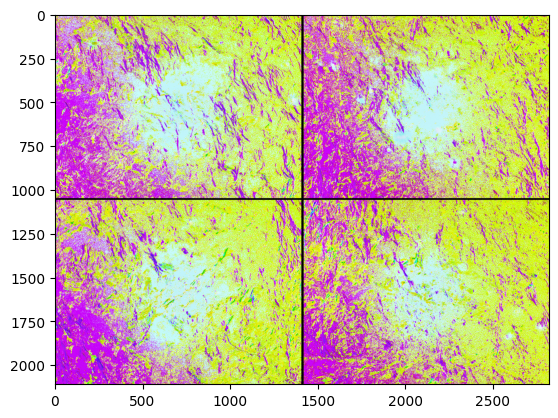

In [47]:
imshow( parr2-narr2)